1. Load libraries and EPlus outputs collection

In [25]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import importlib, inspect

# Caminho para a raiz do projeto (onde está a pasta src)
ROOT = Path().resolve().parent  # se o notebook estiver dentro de uma subpasta, use .parent ou .parents[1]
sys.path.append(str(ROOT))

import src.io_eplus as io_eplus
importlib.reload(io_eplus)  
from src.io_eplus import load_eplus_folder
from src.jos3_runner import run_jos3_hourly

In [26]:
SITE_ID = "MAO"
EPLUS_DIR = Path("../data/eplus") / SITE_ID
PROC_DIR  = Path("../data/processed") / SITE_ID
INTERIM_DIR = Path("../data/interim") / SITE_ID


In [27]:
# Meteorologia + flags (passo 1)
met = pd.read_csv(
    PROC_DIR / "full_timeseries_with_flags_and_metrics.csv.gz",
    parse_dates=["timeset"],
    low_memory=False
)

In [28]:
# EnergyPlus (apenas VN)
vn = load_eplus_folder(EPLUS_DIR, site_id=SITE_ID, tz_str=None, system_filter="vn", wide=True)


Lendo U001_Caso1_1a7_vn_821110_MY.1991.csv (ano 1991, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1992.csv (ano 1992, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1993.csv (ano 1993, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1994.csv (ano 1994, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1995.csv (ano 1995, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1996.csv (ano 1996, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1997.csv (ano 1997, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1998.csv (ano 1998, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.1999.csv (ano 1999, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.2000.csv (ano 2000, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.2001.csv (ano 2001, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.2002.csv (ano 2002, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.2003.csv (ano 2003, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.2004.csv (ano 2004, system=vn)...
Lendo U001_Caso1_1a7_vn_821110_MY.2005.csv (ano 

In [29]:
print("=== QC EnergyPlus (VN) ===")

# Estrutura geral
print(f"Total de registros: {len(vn):,}")
print("Período:",
      vn["timeset"].min().strftime("%Y-%m-%d %H:%M"),
      "→",
      vn["timeset"].max().strftime("%Y-%m-%d %H:%M"))
print("Colunas:", list(vn.columns[:10]), "...")


# Estatísticas de temperatura e umidade
cols_temp = [c for c in vn.columns if c.endswith("Tair_C") or c.endswith("Top_C")]
cols_rh   = [c for c in vn.columns if c.endswith("RH_pct")]
cols_hi   = [c for c in vn.columns if c.endswith("HeatIndex_C")]

def describe_cols(df, cols):
    desc = df[cols].describe().T[["mean","std","min","50%","max"]]
    return desc.round(2)

print("\n--- Temperaturas (°C) ---")
print(describe_cols(vn, cols_temp))

print("\n--- Umidade Relativa (%) ---")
print(describe_cols(vn, cols_rh))

if cols_hi:
    print("\n--- Heat Index (°C) ---")
    print(describe_cols(vn, cols_hi))

# Checagem de NaNs
for c in cols_temp + cols_rh:
    n = vn[c].isna().sum()
    if n > 0:
        print(f"[WARN] {c}: {n} NaN encontrados")

# Zonas detectadas
zones = sorted({c.split("_")[0] for c in vn.columns if "_" in c and not c.startswith("site") and not c.startswith("SCH")})
print("\nZonas detectadas:", ", ".join(zones))

=== QC EnergyPlus (VN) ===
Total de registros: 289,080
Período: 1991-01-01 01:00 → 2024-01-01 00:00
Colunas: ['timeset', 'site_id', 'system', 'year', 'month', 'day', 'hour', 'SALA_Tair_C', 'SALA_Top_C', 'DORM1_Tair_C'] ...

--- Temperaturas (°C) ---
               mean   std    min    50%    max
SALA_Tair_C   30.56  2.15  22.68  30.24  39.81
SALA_Top_C    31.08  2.23  23.60  30.80  40.29
DORM1_Tair_C  30.53  2.39  21.06  30.19  39.48
DORM1_Top_C   30.97  2.28  22.92  30.71  39.39
DORM2_Tair_C  30.54  2.46  22.28  30.19  39.46
DORM2_Top_C   31.03  2.36  24.10  30.75  39.30
BWC_Tair_C    30.42  2.43  23.60  30.00  39.92
BWC_Top_C     30.94  2.42  23.98  30.58  39.91

--- Umidade Relativa (%) ---
               mean   std    min    50%     max
SALA_RH_pct   68.33  8.33  23.91  69.37   96.46
DORM1_RH_pct  68.54  9.23  24.39  69.59   95.65
DORM2_RH_pct  68.53  9.49  23.91  69.54   95.93
BWC_RH_pct    67.83  9.25  22.89  69.22  100.00

--- Heat Index (°C) ---
                    mean   std  

In [30]:
# salva em Parquet (recomendado) e também CSV se quiser inspecionar
out_parquet = INTERIM_DIR / f"eplus_vn.parquet"
out_csv     = INTERIM_DIR / f"eplus_vn.csv.gz"

In [31]:
vn.to_parquet(out_parquet, index=False)
vn.to_csv(out_csv, index=False, compression="gzip")


In [32]:
# EnergyPlus (apenas AC)
ac = load_eplus_folder(EPLUS_DIR, site_id=SITE_ID, tz_str=None, system_filter="ac", wide=True)


Lendo U001_Caso1_1a7_ac_821110_MY.1991.csv (ano 1991, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1992.csv (ano 1992, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1993.csv (ano 1993, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1994.csv (ano 1994, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1995.csv (ano 1995, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1996.csv (ano 1996, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1997.csv (ano 1997, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1998.csv (ano 1998, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.1999.csv (ano 1999, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.2000.csv (ano 2000, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.2001.csv (ano 2001, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.2002.csv (ano 2002, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.2003.csv (ano 2003, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.2004.csv (ano 2004, system=ac)...
Lendo U001_Caso1_1a7_ac_821110_MY.2005.csv (ano 

In [33]:
# === QC EnergyPlus (AC) ===
print("=== QC EnergyPlus (AC) ===")
print(f"Registros: {len(ac):,}")
print("Período:",
      ac["timeset"].min().strftime("%Y-%m-%d %H:%M"),
      "→",
      ac["timeset"].max().strftime("%Y-%m-%d %H:%M"))
print("Colunas:", list(ac.columns[:10]), "...")

# Seleções
cols_e_heat = [c for c in ac.columns if c.endswith("_Heat_E_kWh")]
cols_e_cool = [c for c in ac.columns if c.endswith("_Cool_E_kWh")]
cols_p_heat = [c for c in ac.columns if c.endswith("_Heat_P_W")]
cols_p_cool = [c for c in ac.columns if c.endswith("_Cool_P_W")]

def describe_cols(df, cols):
    if not cols: 
        return "(nenhuma coluna)"
    return df[cols].describe().T[["mean","std","min","50%","max"]].round(2)

# Potência (W) – estatísticas horárias
print("\n--- Potência aquecimento (W) ---")
print(describe_cols(ac, cols_p_heat))
print("\n--- Potência resfriamento (W) ---")
print(describe_cols(ac, cols_p_cool))

# Energia (kWh) – totais no período
def energy_totals_kwh(df, cols, label):
    if not cols:
        print(f"(nenhuma coluna de {label})"); return
    tot = df[cols].sum().sort_values(ascending=False).round(2)
    print(f"\n--- Energia total {label} (kWh) no período ---")
    print(tot.to_string())

energy_totals_kwh(ac, cols_e_heat, "aquecimento")
energy_totals_kwh(ac, cols_e_cool, "resfriamento")

# NaNs
for c in cols_e_heat + cols_e_cool + cols_p_heat + cols_p_cool:
    n = int(ac[c].isna().sum())
    if n: print(f"[WARN] {c}: {n} NaN")

# Zonas detectadas
def zones_from(cols):
    return sorted({c.split("_",1)[0] for c in cols})
zones = sorted(set(zones_from(cols_e_heat + cols_e_cool + cols_p_heat + cols_p_cool)))
print("\nZonas (AC):", ", ".join(zones) if zones else "(nenhuma)")


=== QC EnergyPlus (AC) ===
Registros: 289,080
Período: 1991-01-01 01:00 → 2024-01-01 00:00
Colunas: ['timeset', 'site_id', 'system', 'year', 'month', 'day', 'hour', 'DORM1_Heat_P_W', 'DORM1_Cool_P_W', 'DORM2_Heat_P_W'] ...

--- Potência aquecimento (W) ---
                mean  std  min  50%  max
DORM1_Heat_P_W   0.0  0.0  0.0  0.0  0.0
DORM2_Heat_P_W   0.0  0.0  0.0  0.0  0.0
SALA_Heat_P_W    0.0  0.0  0.0  0.0  0.0

--- Potência resfriamento (W) ---
                  mean      std  min  50%      max
DORM1_Cool_P_W  294.32   369.56  0.0  0.0  1660.01
DORM2_Cool_P_W  287.92   362.98  0.0  0.0  1603.28
SALA_Cool_P_W   911.16  1332.34  0.0  0.0  5528.01

--- Energia total aquecimento (kWh) no período ---
SALA_Heat_E_kWh     0.0
DORM1_Heat_E_kWh    0.0
DORM2_Heat_E_kWh    0.0

--- Energia total resfriamento (kWh) no período ---
SALA_Cool_E_kWh     263396.80
DORM1_Cool_E_kWh     85082.22
DORM2_Cool_E_kWh     83233.12

Zonas (AC): DORM1, DORM2, SALA


In [34]:
# salva em Parquet (recomendado) e também CSV se quiser inspecionar
out_parquet = INTERIM_DIR / f"eplus_ac.parquet"
out_csv     = INTERIM_DIR / f"eplus_ac.csv.gz"

In [35]:
ac.to_parquet(out_parquet, index=False)
ac.to_csv(out_csv, index=False, compression="gzip")


2. JOS3 

In [36]:
# Escolher ZONA (ex.: SALA). Ajuste para DORM1/DORM2/BWC quando quiser.
ZONE = "DORM1"

# checar colunas disponíveis
cols_needed = [f"{ZONE}_Tair_C", f"{ZONE}_Top_C", f"{ZONE}_MRT_C", f"{ZONE}_RH_pct"]
present = [c for c in cols_needed if c in vn.columns]
print("Colunas VN disponíveis p/ zona:", present)

Colunas VN disponíveis p/ zona: ['DORM1_Tair_C', 'DORM1_Top_C', 'DORM1_MRT_C', 'DORM1_RH_pct']


In [37]:
def build_env_inputs(vn: pd.DataFrame, zone: str, default_vel=0.1) -> pd.DataFrame:
    out = vn[["timeset"]].copy()
    # ta
    out["ta"] = vn[f"{zone}_Tair_C"]
    # rh
    rh_col = f"{zone}_RH_pct"
    out["rh"] = vn[rh_col] if rh_col in vn.columns else np.nan

    # tr: preferir MRT; senão aproximar a partir do Top
    tr_col = f"{zone}_MRT_C"
    if tr_col in vn.columns:
        out["tr"] = vn[tr_col]
    else:
        top_col = f"{zone}_Top_C"
        if top_col in vn.columns:
            out["tr"] = 2 * vn[top_col] - vn[f"{zone}_Tair_C"]
        else:
            # fallback conservador: tr ≈ ta
            out["tr"] = out["ta"]

    # vel
    out["vel"] = default_vel
    return out

In [38]:
met_aligned = met[~((met["timeset"].dt.month == 2) & (met["timeset"].dt.day == 29))].copy()

In [39]:
# salva em Parquet (recomendado) e também CSV se quiser inspecionar
out_parquet = INTERIM_DIR / f"met_aligned.parquet"
out_csv     = INTERIM_DIR / f"met_aligned.csv.gz"

met_aligned.to_parquet(out_parquet, index=False)
met_aligned.to_csv(out_csv, index=False, compression="gzip")

print("✅ met_aligned salvo em:")
print("-", out_parquet)
print("-", out_csv)

✅ met_aligned salvo em:
- ..\data\interim\MAO\met_aligned.parquet
- ..\data\interim\MAO\met_aligned.csv.gz


In [40]:
env = build_env_inputs(vn, ZONE, default_vel=0.1)
env

,timeset,ta,rh,tr,vel
0,1991-01-01 01:00:00,27.799737,80.950690,28.689917,0.1
1,1991-01-01 02:00:00,27.111348,81.602077,28.426255,0.1
2,1991-01-01 03:00:00,26.971524,81.198994,28.192924,0.1
3,1991-01-01 04:00:00,27.264744,79.769179,27.986998,0.1
4,1991-01-01 05:00:00,26.531656,82.607924,27.774548,0.1
...,...,...,...,...,...
289075,2023-12-31 20:00:00,32.235265,67.085685,33.632597,0.1
289076,2023-12-31 21:00:00,31.845799,67.620919,33.118173,0.1
289077,2023-12-31 22:00:00,31.423676,70.571079,32.641247,0.1
289078,2023-12-31 23:00:00,31.172568,71.391609,32.234988,0.1


In [41]:
env = env.merge(met_aligned[["timeset","HW_INMET_bool","HW_OU_bool","INMET_hw_id","OUZ_hw_id"]], on="timeset", how="left")

In [42]:
env_1y = env.head(8760).copy()

In [43]:
jos3_out = run_jos3_hourly(
    env=env,
    col_ta="ta",
    col_to="tr",
    col_rh="rh",
    ts_col="timeset",
    dt_seconds=600,
    model_kwargs=dict(
        height=1.7, weight=60, fat=25, age=30, sex="male",
        bmr_equation="japanese", bsa_equation="fujimoto",
        clo=0.5,  # ou outro valor
    ),
)

In [44]:
print(jos3_out.head())
print(jos3_out[["t_core","t_skin_mean","w_mean"]].describe())

              timeset  t_skin_mean     t_core  w_mean
0 1991-01-01 01:00:00    35.209999  36.740002    0.17
1 1991-01-01 02:00:00    35.189999  36.740002    0.17
2 1991-01-01 03:00:00    35.169998  36.740002    0.16
3 1991-01-01 04:00:00    35.139999  36.740002    0.14
4 1991-01-01 05:00:00    35.119999  36.730000    0.14
              t_core    t_skin_mean         w_mean
count  289080.000000  289080.000000  289080.000000
mean       36.787193      35.473953       0.327481
std         0.036613       0.194765       0.126234
min        36.419998      33.700001       0.060000
25%        36.759998      35.330002       0.230000
50%        36.779999      35.480000       0.320000
75%        36.810001      35.619999       0.410000
max        37.240002      36.669998       1.000000


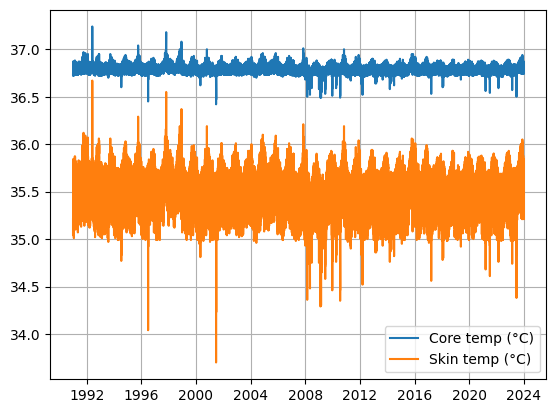

In [45]:
import matplotlib.pyplot as plt
plt.plot(jos3_out["timeset"], jos3_out["t_core"], label="Core temp (°C)")
plt.plot(jos3_out["timeset"], jos3_out["t_skin_mean"], label="Skin temp (°C)")
plt.legend(); plt.grid(); plt.show()

In [46]:
jos3_out.to_csv(PROC_DIR / f"jos3_output_{ZONE}.csv.gz", index=False, compression="gzip")